In [1]:
import datetime
import os
import itertools
import pickle
import numpy as np
import seaborn as sns
import pandas as pd
pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows', 500)

#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:90% !important; }</style>"))

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter

In [2]:
from multiprocessing import cpu_count

import xgboost as xgb
from xgboost import plot_importance

from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, f1_score, precision_score\
                            , recall_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample

import shap

# 0.- Setting global parameters and importing data

In [3]:
seed = 42

In [4]:
train_data = pd.read_csv("data_artifacts/training_features_targets.csv")
display(train_data.info())
train_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9711 entries, 0 to 9710
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   female                      9711 non-null   float64
 1   male                        9711 non-null   float64
 2   graduate_school             9711 non-null   float64
 3   high_school                 9711 non-null   float64
 4   university                  9711 non-null   float64
 5   unknown                     9711 non-null   float64
 6   married                     9711 non-null   float64
 7   single                      9711 non-null   float64
 8   limit_bal                   9711 non-null   float64
 9   age                         9711 non-null   int64  
 10  bal_amt1                    9711 non-null   float64
 11  bal_amt2                    9711 non-null   float64
 12  bal_amt3                    9711 non-null   float64
 13  bal_amt4                    9711 

None

,female,male,graduate_school,high_school,university,unknown,married,single,limit_bal,age,bal_amt1,bal_amt2,bal_amt3,bal_amt4,bal_amt5,bal_amt6,default.payment.next.month
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,50000.0,23,48463.0,47321.0,45791.0,39230.0,26797.0,27364.0,0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,10000.0,25,7025.0,141.0,1239.0,5911.0,-4510.0,10000.0,0
2,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,150000.0,52,86248.0,88033.0,89852.0,90364.0,94431.0,97706.0,1
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,280000.0,26,24189.0,25252.0,26311.0,27638.0,28352.0,29217.0,0
4,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,360000.0,41,0.0,0.0,0.0,0.0,0.0,0.0,1


In [5]:
x = train_data.drop( columns = train_data.columns[-1:])
y = train_data.drop( columns = train_data.columns[:-1])

# 1.0 Data Split
I split the dataset into train/test - 80/20. It would be useful to have a validation dataset, but the dataset small and with some categories with 1 element that I do not have a test validation. This would be useful to have in a production environment. The training is carried out using cross-validation which creates a val dataset for the purpose of training.

In [6]:
(X_train, X_test, Y_train, Y_test) = train_test_split(x, y\
                                                    , test_size = 0.2, random_state= 42\
                                                    , stratify  = y)

In [7]:
# Separate majority and minority classes
index_majority = Y_train[Y_train['default.payment.next.month'] == 0].index.values
index_minority = Y_train[Y_train['default.payment.next.month'] == 1].index.values

df_majority = X_train.loc[index_majority,:]
df_minority = X_train.loc[index_minority,:]

print('df_majority.shape', df_majority.shape, 'df_minority.shape', df_minority.shape)

# Upsample minority class
df_minority_upsampled = resample(df_minority 
                                 , replace      = True     # sample with replacement
                                 , n_samples    = df_majority.shape[0]    # to match majority class
                                 , random_state = 42) # reproducible results

print('df_majority.shape:', df_majority.shape, 'df_minority_upsampled.shape:', df_minority_upsampled.shape)

# Combine majority class with upsampled minority class
X_train_upsampled = pd.concat([df_majority, df_minority_upsampled])
Y_train_upsampled = Y_train.loc[X_train_upsampled.index,:]

X_train_upsampled = X_train_upsampled.reset_index(drop=True)
Y_train_upsampled = Y_train_upsampled.reset_index(drop=True)
 
# Display new class counts
print('X_train_upsampled.shape:', X_train_upsampled.shape)
print('Y_train_upsampled.shape:', Y_train_upsampled.shape)
#training_data_upsampled['default.payment.next.month'].value_counts()

df_majority.shape (6014, 16) df_minority.shape (1754, 16)
df_majority.shape: (6014, 16) df_minority_upsampled.shape: (6014, 16)
X_train_upsampled.shape: (12028, 16)
Y_train_upsampled.shape: (12028, 1)


In [8]:
X_train.to_csv('data_artifacts/X_train.csv', index = False)
X_train_upsampled.to_csv('data_artifacts/X_train_upsampled.csv', index = False)
X_test.to_csv('data_artifacts/X_test.csv', index = False)
Y_train.to_csv('data_artifacts/Y_train.csv', index = False)
Y_train_upsampled.to_csv('data_artifacts/Y_train_upsampled.csv', index = False)
Y_test.to_csv('data_artifacts/Y_test.csv', index = False)

# 2.0 Model Training

While I don't normalise the data for the XGBoost model, it could have been useful if I were comparing different models some of which might require data scaling (linear regression).
https://datascience.stackexchange.com/questions/60950/is-it-necessary-to-normalise-data-for-xgboost#:~:text=2%20Answers&text=Your%20rationale%20is%20indeed%20correct,normalization%20for%20the%20inputs%20either

https://github.com/dmlc/xgboost/issues/357

Also, XGBoost takes care of multicolinearity by default, which is another useful feature of the model.

## 2.1 XGBoost classifier model baseline

In [9]:
eval_metric = ['logloss', 'auc'] #'merror',

In [10]:
xgb_baseline         = xgb.XGBClassifier(random_state = seed, n_jobs=cpu_count()//2) #seed)
eval_set             = [(X_train_upsampled.values, Y_train_upsampled.values), (X_test.values, Y_test.values)]
trained_xgb_baseline = xgb_baseline.fit(X_train_upsampled.values, Y_train_upsampled.values\
                                        , eval_metric = eval_metric \
                                        , eval_set = eval_set, verbose=True)
trained_xgb_baseline = xgb_baseline.fit(X_train_upsampled, Y_train_upsampled, eval_metric = eval_metric)
feature_importances  = xgb_baseline.feature_importances_ 

[0]	validation_0-logloss:0.65809	validation_0-auc:0.70994	validation_1-logloss:0.67519	validation_1-auc:0.61035
[1]	validation_0-logloss:0.63597	validation_0-auc:0.72785	validation_1-logloss:0.66446	validation_1-auc:0.62625
[2]	validation_0-logloss:0.61939	validation_0-auc:0.74872	validation_1-logloss:0.66097	validation_1-auc:0.62184
[3]	validation_0-logloss:0.60588	validation_0-auc:0.76061	validation_1-logloss:0.65433	validation_1-auc:0.63487
[4]	validation_0-logloss:0.59586	validation_0-auc:0.76859	validation_1-logloss:0.64966	validation_1-auc:0.64211
[5]	validation_0-logloss:0.58442	validation_0-auc:0.78069	validation_1-logloss:0.64673	validation_1-auc:0.64377
[6]	validation_0-logloss:0.57660	validation_0-auc:0.78997	validation_1-logloss:0.64422	validation_1-auc:0.64495
[7]	validation_0-logloss:0.57241	validation_0-auc:0.79421	validation_1-logloss:0.64311	validation_1-auc:0.64700
[8]	validation_0-logloss:0.56034	validation_0-auc:0.80695	validation_1-logloss:0.63939	validation_1-auc:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[19]	validation_0-logloss:0.51358	validation_0-auc:0.85188	validation_1-logloss:0.63232	validation_1-auc:0.64296
[20]	validation_0-logloss:0.51218	validation_0-auc:0.85276	validation_1-logloss:0.63111	validation_1-auc:0.64423
[21]	validation_0-logloss:0.50869	validation_0-auc:0.85647	validation_1-logloss:0.63159	validation_1-auc:0.64334
[22]	validation_0-logloss:0.49852	validation_0-auc:0.86780	validation_1-logloss:0.62891	validation_1-auc:0.64346
[23]	validation_0-logloss:0.49778	validation_0-auc:0.86858	validation_1-logloss:0.62887	validation_1-auc:0.64293
[24]	validation_0-logloss:0.49551	validation_0-auc:0.87041	validation_1-logloss:0.62842	validation_1-auc:0.64310
[25]	validation_0-logloss:0.48889	validation_0-auc:0.87736	validation_1-logloss:0.62684	validation_1-auc:0.64144
[26]	validation_0-logloss:0.48657	validation_0-auc:0.87909	validation_1-logloss:0.62673	validation_1-auc:0.64165
[27]	validation_0-logloss:0.48101	validation_0-auc:0.88466	validation_1-logloss:0.62445	validati

[92]	validation_0-logloss:0.30282	validation_0-auc:0.98047	validation_1-logloss:0.59861	validation_1-auc:0.64489
[93]	validation_0-logloss:0.30217	validation_0-auc:0.98055	validation_1-logloss:0.59977	validation_1-auc:0.64376
[94]	validation_0-logloss:0.29968	validation_0-auc:0.98122	validation_1-logloss:0.59897	validation_1-auc:0.64352
[95]	validation_0-logloss:0.29834	validation_0-auc:0.98163	validation_1-logloss:0.59880	validation_1-auc:0.64324
[96]	validation_0-logloss:0.29628	validation_0-auc:0.98209	validation_1-logloss:0.59846	validation_1-auc:0.64398
[97]	validation_0-logloss:0.29557	validation_0-auc:0.98225	validation_1-logloss:0.59837	validation_1-auc:0.64418
[98]	validation_0-logloss:0.29197	validation_0-auc:0.98299	validation_1-logloss:0.59787	validation_1-auc:0.64461
[99]	validation_0-logloss:0.29064	validation_0-auc:0.98318	validation_1-logloss:0.59804	validation_1-auc:0.64427


In [11]:
file_name = "model_artifacts/xgb_baseline.pkl"

# save
pickle.dump(trained_xgb_baseline, open(file_name, "wb"))

# load
trained_xgb_baseline = pickle.load(open(file_name, "rb"))

### 2.1.1 Checking overfitting/underfitting & on number of trees using rmse and mae
This should check should truly be done using a test/val dataset, hence in this case is used for illustration purposes.

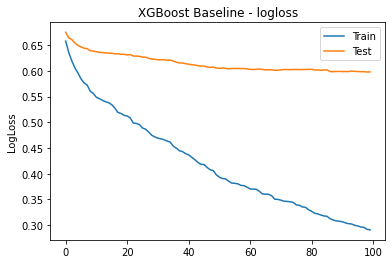

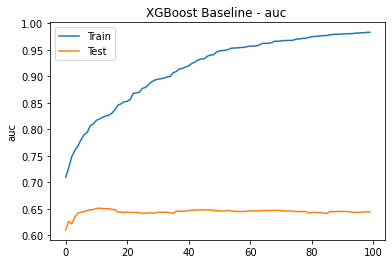

In [48]:
results = trained_xgb_baseline.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('LogLoss')
plt.title('XGBoost Baseline - logloss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('auc')
plt.title('XGBoost Baseline - auc ')
plt.show()

### 2.1.2 Baseline metrics

In [13]:
def try_func(func, y_data, predictions):
    try:
        return func(y_data,predictions).round(2)
    except Exception as E:
        print(E)
        return np.nan

def calc_metrics(classifier, x_data, y_data):

    shape_x, shape_y = (x_data.shape, y_data.shape)
    print('Data shapes X:', shape_x, 'Y:', shape_y)
    predictions = classifier.predict(x_data) 

    
    acc  = try_func(accuracy_score, y_data, predictions)
    f1   = try_func(f1_score, y_data, predictions)
    prec = try_func(precision_score, y_data, predictions)
    rec  = try_func(recall_score, y_data, predictions)
    print('Metrics model -', 'accuracy:', acc, 'f1:', f1, 'precision:', prec, 'recall:', rec) 
    roc  = try_func(roc_auc_score, y_data, predictions)
    

    print('Metrics model -', 'accuracy:', acc, 'f1:', f1, 'precision:', prec, 'recall:', rec, 'roc_auc:', roc) 
    return [acc, f1, prec, rec, roc, shape_x, shape_y]

In [14]:
print("Metrics XGB classifier baseline on train data")
results_baseline_train = calc_metrics(trained_xgb_baseline, X_train_upsampled.values, Y_train_upsampled.values)

Metrics XGB classifier baseline on train data
Data shapes X: (12028, 16) Y: (12028, 1)
Metrics model - accuracy: 0.93 f1: 0.93 precision: 0.9 recall: 0.97
Metrics model - accuracy: 0.93 f1: 0.93 precision: 0.9 recall: 0.97 roc_auc: 0.93


In [15]:
print("Metrics XGB classifier baseline on test data")
results_baseline_test = calc_metrics(trained_xgb_baseline, X_test.values, Y_test.values)

Metrics XGB classifier baseline on test data
Data shapes X: (1943, 16) Y: (1943, 1)
Metrics model - accuracy: 0.69 f1: 0.39 precision: 0.35 recall: 0.44
Metrics model - accuracy: 0.69 f1: 0.39 precision: 0.35 recall: 0.44 roc_auc: 0.6


# 2.2 Fine tuning the XGB model (takes about 4 mins in 6 core laptop)

### I take inspiration from here https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [16]:
XGB_Options = { 
                'n_jobs':           1, #cpu_count()//2,
                'cv':               3,
                'scoring':          'roc_auc',#'roc_auc',
                'seed':             seed, 
    
                'max_depth':        np.arange(2,12,4),
                'min_child_weight': np.arange(1,10,3),
                'n_estimators':     [50, 100, 200], 

                'gamma':            np.arange(0.05,0.45,0.15),
                'colsample_bytree': np.arange(0.60, 0.95, 0.15),
                'subsample':        np.arange(0.60, 0.95, 0.15),
                'reg_alpha':        [1e-6, 1, 10], 
                'reg_lambda':       [1e-6, 1, 10],
                'learning_rate':    np.arange(0.025,0.150,0.050),
                 'verbose':         1            
              }

In [17]:
#xgb_reg = xgb.XGBRegressor(random_state=XGB_Options['seed'], n_jobs=cpu_count()//2) 
xgb_reg = xgb.XGBClassifier(random_state = XGB_Options['seed']\
                            , n_jobs = cpu_count()//2\
                            , eval_metric = eval_metric, use_label_encoder=False) 
start = datetime.datetime.now()
print('Starting with low learning rate and tuning: max_depth, min_child_weight, n_estimators')

params = {  
    "learning_rate":     [0.1],
    "max_depth":         XGB_Options['max_depth'], 
    "min_child_weight":  XGB_Options['min_child_weight'], 
    "n_estimators":      XGB_Options['n_estimators'], 

    "colsample_bytree":  [0.8], 
    "subsample":         [0.8],
    "gamma":             [0],
}

GSCV = GridSearchCV(xgb_reg, 
                    params,
                    cv                 = XGB_Options['cv'],
                    scoring            = XGB_Options['scoring'], 
                    n_jobs             = XGB_Options['n_jobs'], 
                    verbose            = XGB_Options['verbose'], 
                    return_train_score = True)

GSCV.fit(X_train_upsampled.values, Y_train_upsampled.values)
end = datetime.datetime.now()

print('Time to fit', (end-start))
print('best_params_:', GSCV.best_params_)#, 
print('best_score_:',  GSCV.best_score_)

print('Tuning: gamma')
start = datetime.datetime.now()
params = {  
    "learning_rate":    [0.1], 
    "max_depth":        [GSCV.best_params_['max_depth']],
    "min_child_weight": [GSCV.best_params_['min_child_weight']],
    "n_estimators":     [GSCV.best_params_['n_estimators']],

    "colsample_bytree": [0.8], 
    "subsample":        [0.8],
    "gamma":            XGB_Options['gamma'],

}

GSCV = GridSearchCV(xgb_reg, 
                    params,
                    cv                 = XGB_Options['cv'],
                    scoring            = XGB_Options['scoring'], 
                    n_jobs             = XGB_Options['n_jobs'],
                    verbose            = XGB_Options['verbose'], 
                    return_train_score = True)

GSCV.fit(X_train_upsampled.values, Y_train_upsampled.values)
end = datetime.datetime.now()

print('Time to fit xgb', (end-start))
print('best_params_:', GSCV.best_params_)#, 
print('best_score_:', GSCV.best_score_)


print('Tuning: colsample_bytree, subsample')
start = datetime.datetime.now()

params = {  
    "learning_rate":    [0.1], 
    "max_depth":        [GSCV.best_params_['max_depth']],
    "min_child_weight": [GSCV.best_params_['min_child_weight']],
    "n_estimators":     [GSCV.best_params_['n_estimators']],
    "gamma":            [GSCV.best_params_['gamma']],

    "colsample_bytree": XGB_Options['colsample_bytree'],
    "subsample":        XGB_Options['subsample'],

}

GSCV = GridSearchCV(xgb_reg, 
                    params,
                    cv                 = XGB_Options['cv'],
                    scoring            = XGB_Options['scoring'], 
                    n_jobs             = XGB_Options['n_jobs'],
                    verbose            = XGB_Options['verbose'], 
                    return_train_score = True)

GSCV.fit(X_train_upsampled.values, Y_train_upsampled.values)
end = datetime.datetime.now()

print('Time to fit', (end-start))
print('best_params_:', GSCV.best_params_) 
print('best_score_:', GSCV.best_score_)

print('Tuning: reg_alpha, reg_lambda')
start = datetime.datetime.now()
params = {  
    "learning_rate":    [0.1], 
    "max_depth":        [GSCV.best_params_['max_depth']],
    "min_child_weight": [GSCV.best_params_['min_child_weight']],
    "n_estimators":     [GSCV.best_params_['n_estimators']],
    "gamma":            [GSCV.best_params_['gamma']],

    "colsample_bytree": [GSCV.best_params_['colsample_bytree']], 
    "subsample":        [GSCV.best_params_['subsample']],


    "reg_alpha":        XGB_Options['reg_alpha'], 
    "reg_lambda":       XGB_Options['reg_lambda'], 
}

GSCV = GridSearchCV(xgb_reg, 
                    params,
                    cv                 = XGB_Options['cv'],
                    scoring            = XGB_Options['scoring'], 
                    n_jobs             = XGB_Options['n_jobs'],
                    verbose            = XGB_Options['verbose'], 
                    return_train_score = True)

GSCV.fit(X_train_upsampled.values, Y_train_upsampled.values)
end = datetime.datetime.now()

print('Time to fit', (end-start))
print('best_params_:', GSCV.best_params_)
print('best_score_:', GSCV.best_score_)


print('Tuning: learning_rate')
start = datetime.datetime.now()

params = {  
    "learning_rate":    XGB_Options['learning_rate'], 
    "max_depth":        [GSCV.best_params_['max_depth']],
    "min_child_weight": [GSCV.best_params_['min_child_weight']],
    "n_estimators":     [GSCV.best_params_['n_estimators']],
    "gamma":            [GSCV.best_params_['gamma']],

    "colsample_bytree": [GSCV.best_params_['colsample_bytree']], 
    "subsample":        [GSCV.best_params_['subsample']],


    "reg_alpha":        [GSCV.best_params_['reg_alpha']],
    "reg_lambda":       [GSCV.best_params_['reg_lambda']]
}

GSCV = GridSearchCV(xgb_reg, 
                    params,
                    cv                 = XGB_Options['cv'],
                    scoring            = XGB_Options['scoring'], 
                    n_jobs             = XGB_Options['n_jobs'],
                    verbose            = XGB_Options['verbose'], 
                    return_train_score = True)

GSCV.fit(X_train_upsampled.values, Y_train_upsampled.values) 
end = datetime.datetime.now()

print('Time to fit', (end-start))
print('best_params_:', GSCV.best_params_)
print('best_score_:', GSCV.best_score_)

Starting with low learning rate and tuning: max_depth, min_child_weight, n_estimators
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Time to fit 0:00:43.454376
best_params_: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}
best_score_: 0.9371301755044894
Tuning: gamma
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Time to fit xgb 0:00:15.990208
best_params_: {'colsample_bytree': 0.8, 'gamma': 0.05, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}
best_score_: 0.9371465370409876
Tuning: colsample_bytree, subsample
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Time to fit 0:00:47.187688
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.05, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}
best_score_: 0.9379018259027371
Tuning: reg_alpha, reg_lambda
Fitting 

In [18]:
# Regression
start = datetime.datetime.now()
xgb_tuned           = xgb.XGBClassifier(random_state=XGB_Options['seed']\
                                        , n_jobs=cpu_count()//2\
                                        , use_label_encoder=False) #seed)
xgb_tuned.set_params(**GSCV.best_params_)
trained_xgb_tuned   = xgb_tuned.fit(X_train_upsampled.values, Y_train_upsampled.values\
                                    , eval_metric = eval_metric \
                                    , eval_set = eval_set, verbose=False)
feature_importances = trained_xgb_tuned.feature_importances_ 
end = datetime.datetime.now()
print('Time to fit xgb', (end-start))

Time to fit xgb 0:00:07.402559


### 2.2.1 Tuned Model Metrics

In [19]:
file_name = "model_artifacts/xgb_tuned.pkl"

# save
pickle.dump(trained_xgb_tuned, open(file_name, "wb"))

# load
trained_xgb_tuned = pickle.load(open(file_name, "rb"))

In [20]:
print("Metrics XGB classifier tuned on train data")
metrics_tuned_model_train = calc_metrics(trained_xgb_tuned, X_train_upsampled.values, Y_train_upsampled.values)

Metrics XGB classifier tuned on train data
Data shapes X: (12028, 16) Y: (12028, 1)
Metrics model - accuracy: 1.0 f1: 1.0 precision: 1.0 recall: 1.0
Metrics model - accuracy: 1.0 f1: 1.0 precision: 1.0 recall: 1.0 roc_auc: 1.0


In [21]:
print("Metrics XGB classifier tuned on test data")
metrics_tuned_model_test =  calc_metrics(trained_xgb_tuned, X_test.values, Y_test.values)

Metrics XGB classifier tuned on test data
Data shapes X: (1943, 16) Y: (1943, 1)
Metrics model - accuracy: 0.74 f1: 0.29 precision: 0.38 recall: 0.24
Metrics model - accuracy: 0.74 f1: 0.29 precision: 0.38 recall: 0.24 roc_auc: 0.56


### 2.2.2 Comparing Metrics with baseline

Considering the results in 2.1.2 the 'tuned' model performs better than the baseline model. Though this seems to come from a more complex model, as it's a lot deeper and with more boosting operations than the baseline. An issue that this could cause is overfitting, i.e. if this model was deployed to production it's performance might not be as good as in this offline setting.

In [22]:
metrics_names = ['accuracy_score', 'f1_score', 'precision_score', 'recall_score', 'roc_auc_score'\
                 , 'shape_x', 'shape_y']
columns = ['subset', 'sex', 'education', 'marriage' ] + metrics_names
metrics = pd.DataFrame([ ['Train'] + ['All'] + ['All'] + ['All'] + metrics_tuned_model_train\
                         , ['Test'] + ['All'] + ['All'] + ['All'] + metrics_tuned_model_test]\
                       , columns = columns)
metrics

,subset,sex,education,marriage,accuracy_score,f1_score,precision_score,recall_score,roc_auc_score,shape_x,shape_y
0,Train,All,All,All,1.00,1.00,1.00,1.00,1.00,"(12028, 16)","(12028, 1)"
1,Test,All,All,All,0.74,0.29,0.38,0.24,0.56,"(1943, 16)","(1943, 1)"


### 2.2.3 Model Metrics per category In/Out

In [23]:
combination_categories = pd.read_csv('data_artifacts/combination_categories.csv')
combination_categories

,SEX,EDUCATION,MARRIAGE,counts
0,female,university,married,1517
1,female,graduate_school,single,1403
2,female,university,single,1323
3,male,university,single,926
4,male,graduate_school,single,912
5,male,university,married,751
6,female,graduate_school,married,653
7,female,high_school,married,603
8,male,graduate_school,married,528
9,female,high_school,single,338


In [24]:
metric_datasets = [['Train', X_train_upsampled, Y_train_upsampled], ['Test', X_test, Y_test]]

for subset, dataset_x, dataset_y in metric_datasets:
    for i, row in combination_categories.iterrows():

        x_test_cat = dataset_x[ (dataset_x[row.SEX] == 1) \
                               & (dataset_x[row.EDUCATION] == 1)\
                               & (dataset_x[row.MARRIAGE] == 1)]
        y_test_cat = dataset_y.loc[x_test_cat.index, :]

        print('subset:', subset,'SEX:', row.SEX, 'EDUCATION:', row.EDUCATION, 'MARRIAGE:', row.MARRIAGE)
        """
        try: 
            results_cat = calc_metrics(trained_xgb_tuned, x_test_cat.values, y_test_cat.values)
        except Exception as E:
            print(E)
            pass
        """
        results_cat = calc_metrics(trained_xgb_tuned, x_test_cat.values, y_test_cat.values)        
        aux_df      = pd.DataFrame([ [subset] + [row.SEX] + [row.EDUCATION] + [row.MARRIAGE] +  results_cat]\
                               , columns = columns)    
    
        metrics     = metrics.append(aux_df)

        print('\n')

subset: Train SEX: female EDUCATION: university MARRIAGE: married
Data shapes X: (1900, 16) Y: (1900, 1)
Metrics model - accuracy: 1.0 f1: 1.0 precision: 0.99 recall: 1.0
Metrics model - accuracy: 1.0 f1: 1.0 precision: 0.99 recall: 1.0 roc_auc: 1.0


subset: Train SEX: female EDUCATION: graduate_school MARRIAGE: single
Data shapes X: (1634, 16) Y: (1634, 1)
Metrics model - accuracy: 0.99 f1: 0.99 precision: 0.99 recall: 0.99
Metrics model - accuracy: 0.99 f1: 0.99 precision: 0.99 recall: 0.99 roc_auc: 0.99


subset: Train SEX: female EDUCATION: university MARRIAGE: single
Data shapes X: (1647, 16) Y: (1647, 1)
Metrics model - accuracy: 1.0 f1: 1.0 precision: 1.0 recall: 1.0
Metrics model - accuracy: 1.0 f1: 1.0 precision: 1.0 recall: 1.0 roc_auc: 1.0


subset: Train SEX: male EDUCATION: university MARRIAGE: single
Data shapes X: (1206, 16) Y: (1206, 1)
Metrics model - accuracy: 1.0 f1: 1.0 precision: 1.0 recall: 1.0
Metrics model - accuracy: 1.0 f1: 1.0 precision: 1.0 recall: 1.0 roc_

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.


Metrics model - accuracy: 0.7 f1: 0.21 precision: 0.31 recall: 0.16 roc_auc: 0.52


subset: Test SEX: female EDUCATION: graduate_school MARRIAGE: single
Data shapes X: (290, 16) Y: (290, 1)
Metrics model - accuracy: 0.8 f1: 0.27 precision: 0.37 recall: 0.22
Metrics model - accuracy: 0.8 f1: 0.27 precision: 0.37 recall: 0.22 roc_auc: 0.57


subset: Test SEX: female EDUCATION: university MARRIAGE: single
Data shapes X: (274, 16) Y: (274, 1)
Metrics model - accuracy: 0.77 f1: 0.32 precision: 0.41 recall: 0.27
Metrics model - accuracy: 0.77 f1: 0.32 precision: 0.41 recall: 0.27 roc_auc: 0.58


subset: Test SEX: male EDUCATION: university MARRIAGE: single
Data shapes X: (189, 16) Y: (189, 1)
Metrics model - accuracy: 0.7 f1: 0.31 precision: 0.37 recall: 0.27
Metrics model - accuracy: 0.7 f1: 0.31 precision: 0.37 recall: 0.27 roc_auc: 0.56


subset: Test SEX: male EDUCATION: graduate_school MARRIAGE: single
Data shapes X: (167, 16) Y: (167, 1)
Metrics model - accuracy: 0.8 f1: 0.29 precision

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.


In [25]:
metrics

,subset,sex,education,marriage,accuracy_score,f1_score,precision_score,recall_score,roc_auc_score,shape_x,shape_y
0,Train,All,All,All,1.00,1.00,1.00,1.00,1.00,"(12028, 16)","(12028, 1)"
1,Test,All,All,All,0.74,0.29,0.38,0.24,0.56,"(1943, 16)","(1943, 1)"
0,Train,female,university,married,1.00,1.00,0.99,1.00,1.00,"(1900, 16)","(1900, 1)"
0,Train,female,graduate_school,single,0.99,0.99,0.99,0.99,0.99,"(1634, 16)","(1634, 1)"
0,Train,female,university,single,1.00,1.00,1.00,1.00,1.00,"(1647, 16)","(1647, 1)"
0,Train,male,university,single,1.00,1.00,1.00,1.00,1.00,"(1206, 16)","(1206, 1)"
0,Train,male,graduate_school,single,0.99,0.99,0.98,1.00,0.99,"(1089, 16)","(1089, 1)"
0,Train,male,university,married,1.00,1.00,1.00,1.00,1.00,"(1015, 16)","(1015, 1)"
0,Train,female,graduate_school,married,0.99,0.98,0.99,0.98,0.99,"(778, 16)","(778, 1)"
0,Train,female,high_school,married,1.00,1.00,1.00,1.00,1.00,"(760, 16)","(760, 1)"


In [26]:
metrics[ metrics.roc_auc_score.isnull()]

,subset,sex,education,marriage,accuracy_score,f1_score,precision_score,recall_score,roc_auc_score,shape_x,shape_y
0,Train,male,unknown,single,1.0,0.0,0.0,0.0,NaN,"(18, 16)","(18, 1)"
0,Test,female,unknown,single,1.0,0.0,0.0,0.0,NaN,"(2, 16)","(2, 1)"
0,Test,male,unknown,single,1.0,0.0,0.0,0.0,NaN,"(4, 16)","(4, 1)"


In [27]:
metrics[(metrics.sex == 'All') & (metrics.education == 'All') & (metrics.marriage == 'All') ]

,subset,sex,education,marriage,accuracy_score,f1_score,precision_score,recall_score,roc_auc_score,shape_x,shape_y
0,Train,All,All,All,1.00,1.00,1.00,1.00,1.00,"(12028, 16)","(12028, 1)"
1,Test,All,All,All,0.74,0.29,0.38,0.24,0.56,"(1943, 16)","(1943, 1)"


### 2.2.4 Metrics by categories  - visualisation

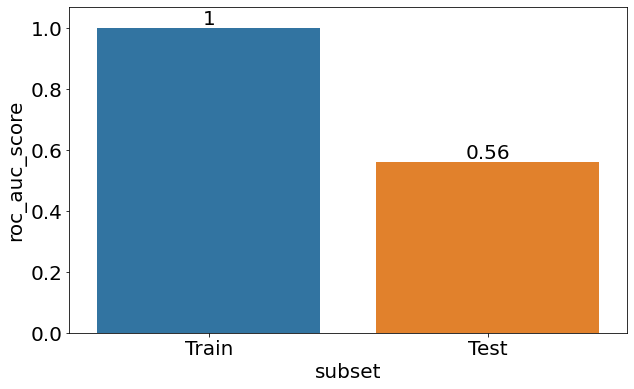

In [28]:
plot_df = metrics[ (metrics['sex'] =='All') & (metrics['education'] =='All') & (metrics['marriage'] =='All')]

plt.figure(figsize = (10, 6))
plot_metric = "roc_auc_score"
ax          = sns.barplot(x = "subset", y = plot_metric, data = plot_df)

for container in ax.containers:
    ax.bar_label(container, fontsize = 20)

ax.set_xlabel(ax.get_xlabel(), fontsize = 20);
ax.set_ylabel(ax.get_ylabel(), fontsize = 20);

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(20)

    
ax.set_ylim(0, 1.07);

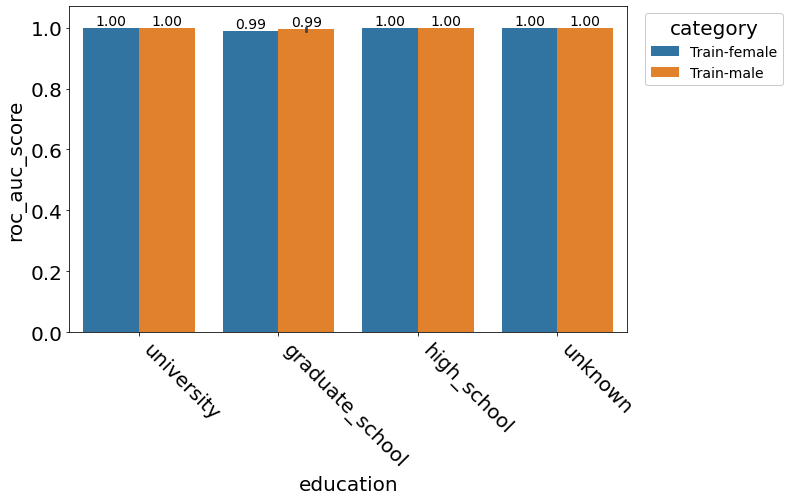

In [29]:
plot_df = metrics[ (metrics['sex'] !='All') & (metrics['subset'] == 'Train')].copy()
plot_df['category'] = plot_df['subset'] + '-' + plot_df['sex']

plt.figure(figsize = (10, 6))
plot_metric = "roc_auc_score"
ax = sns.barplot(x="education", y = plot_metric, hue = 'category', data= plot_df)
#ax = sns.barplot(x = "education", y = plot_metric, hue = 'sex', data= plot_df)

plt.xticks(rotation=-45, ha='left');    

for container in ax.containers:
    ax.bar_label(container, fontsize = 14, fmt='%.2f')
    
ax.set_xlabel(ax.get_xlabel(), fontsize = 20);
ax.set_ylabel(ax.get_ylabel(), fontsize = 20);

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    #label.set_fontname('Arial')
    label.set_fontsize(20)

#plt.legend(fontsize = 20)
#plt.setp( plt.gca().get_legend().get_title(),fontsize= 20);
ax.set_ylim(0, 1.07)
ax.legend(bbox_to_anchor=(1.02, 1.0), framealpha = 1, fontsize = 14, 
          title_fontsize = 20,title=ax.legend_.get_title().get_text());

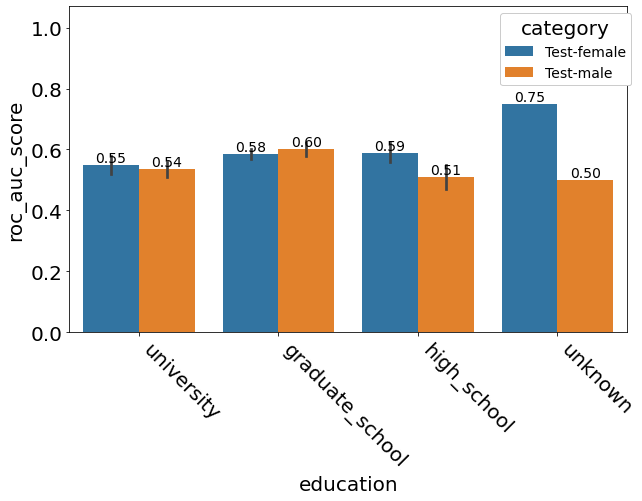

In [30]:
plot_df = metrics[ (metrics['sex'] !='All') & (metrics['subset'] == 'Test')].copy()
plot_df['category'] = plot_df['subset'] + '-' + plot_df['sex']

plt.figure(figsize = (10, 6))
plot_metric = "roc_auc_score"
ax = sns.barplot(x="education", y = plot_metric, hue = 'category', data= plot_df)
#ax = sns.barplot(x = "education", y = plot_metric, hue = 'sex', data= plot_df)

plt.xticks(rotation=-45, ha='left');    

for container in ax.containers:
    ax.bar_label(container, fontsize = 14, fmt='%.2f')
    
ax.set_xlabel(ax.get_xlabel(), fontsize = 20);
ax.set_ylabel(ax.get_ylabel(), fontsize = 20);

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    #label.set_fontname('Arial')
    label.set_fontsize(20)

#plt.legend(fontsize = 20)
#plt.setp( plt.gca().get_legend().get_title(),fontsize= 20);
ax.set_ylim(0, 1.07)
ax.legend(bbox_to_anchor=(1.02, 1.0), framealpha = 1, fontsize = 14, 
          title_fontsize = 20,title=ax.legend_.get_title().get_text());

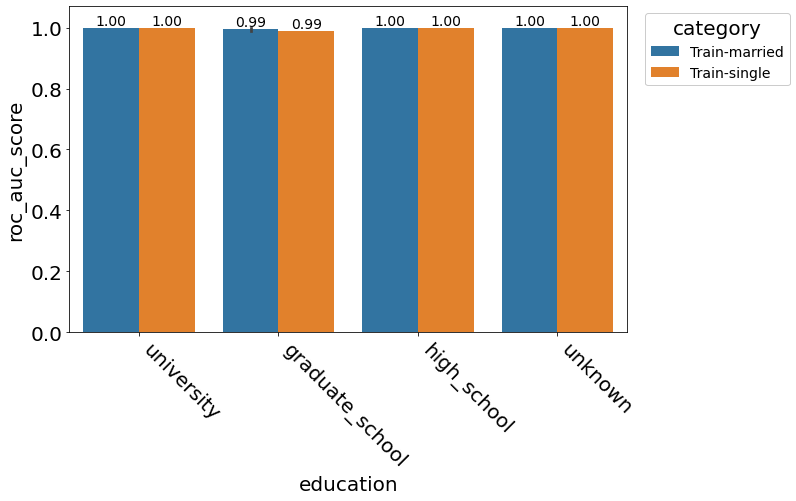

In [31]:
plot_df = metrics[ (metrics['marriage'] !='All') & (metrics['subset'] == 'Train')].copy()
plot_df['category'] = plot_df['subset'] + '-' + plot_df['marriage']

plt.figure(figsize = (10, 6))
plot_metric = "roc_auc_score"
ax = sns.barplot(x="education", y = plot_metric, hue = 'category', data= plot_df)
#ax = sns.barplot(x = "education", y = plot_metric, hue = 'sex', data= plot_df)

plt.xticks(rotation=-45, ha='left');    

for container in ax.containers:
    ax.bar_label(container, fontsize = 14, fmt='%.2f')
    
ax.set_xlabel(ax.get_xlabel(), fontsize = 20);
ax.set_ylabel(ax.get_ylabel(), fontsize = 20);

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    #label.set_fontname('Arial')
    label.set_fontsize(20)

#plt.legend(fontsize = 20)
#plt.setp( plt.gca().get_legend().get_title(),fontsize= 20);
ax.set_ylim(0, 1.07)
ax.legend(bbox_to_anchor=(1.02, 1.0), framealpha = 1, fontsize = 14, 
          title_fontsize = 20,title=ax.legend_.get_title().get_text());

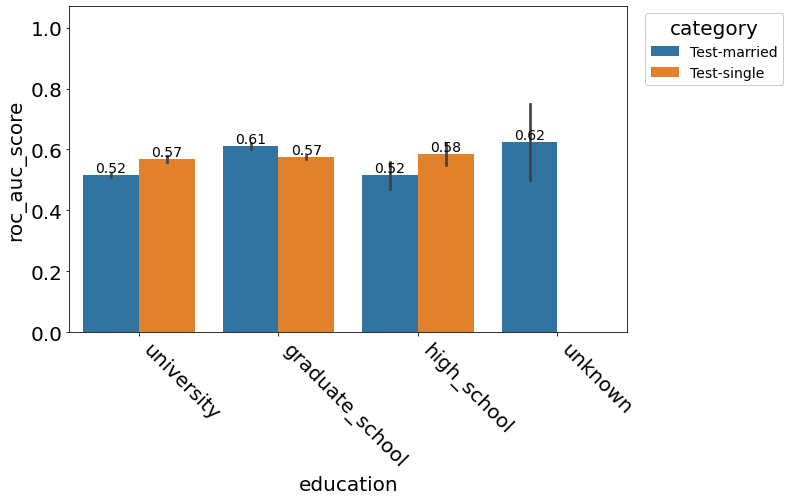

In [32]:
plot_df = metrics[ (metrics['marriage'] !='All') & (metrics['subset'] == 'Test')].copy()
plot_df['category'] = plot_df['subset'] + '-' + plot_df['marriage']

plt.figure(figsize = (10, 6))
plot_metric = "roc_auc_score"
ax = sns.barplot(x="education", y = plot_metric, hue = 'category', data= plot_df)
#ax = sns.barplot(x = "education", y = plot_metric, hue = 'sex', data= plot_df)

plt.xticks(rotation=-45, ha='left');    

for container in ax.containers:
    ax.bar_label(container, fontsize = 14, fmt='%.2f')
    
ax.set_xlabel(ax.get_xlabel(), fontsize = 20);
ax.set_ylabel(ax.get_ylabel(), fontsize = 20);

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    #label.set_fontname('Arial')
    label.set_fontsize(20)

#plt.legend(fontsize = 20)
#plt.setp( plt.gca().get_legend().get_title(),fontsize= 20);
ax.set_ylim(0, 1.07)
ax.legend(bbox_to_anchor=(1.02, 1.0), framealpha = 1, fontsize = 14, 
          title_fontsize = 20,title=ax.legend_.get_title().get_text());

# 3.0  Feature importance

## 3.1 Weight, Gain, Cover

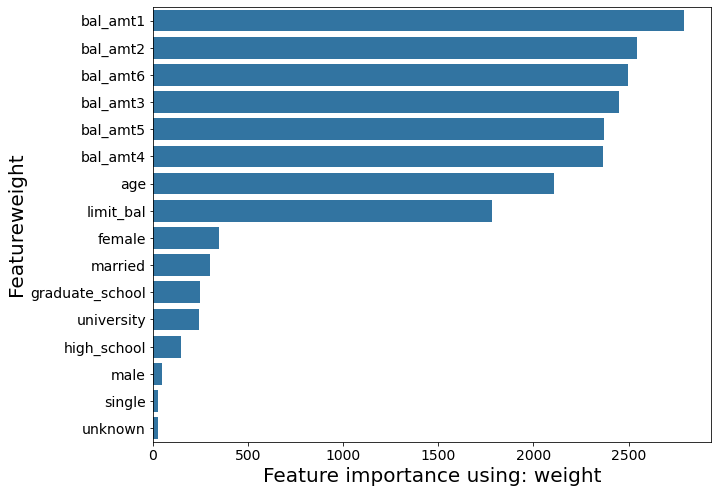

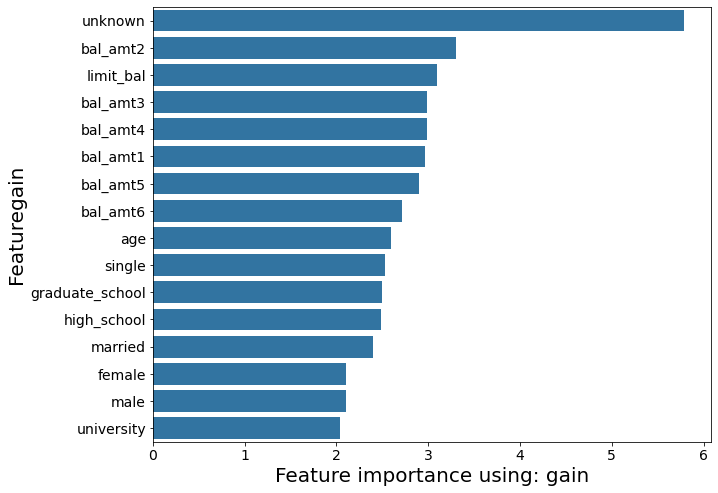

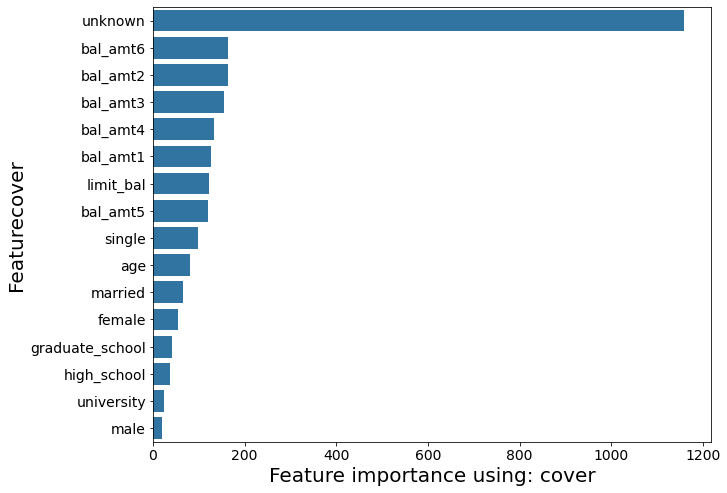

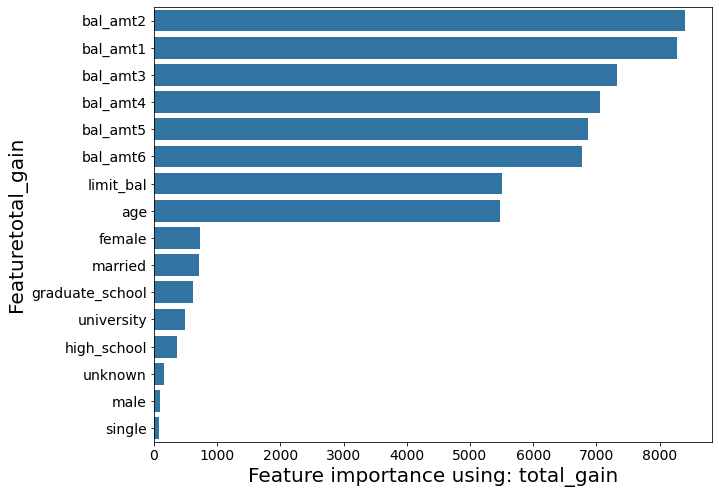

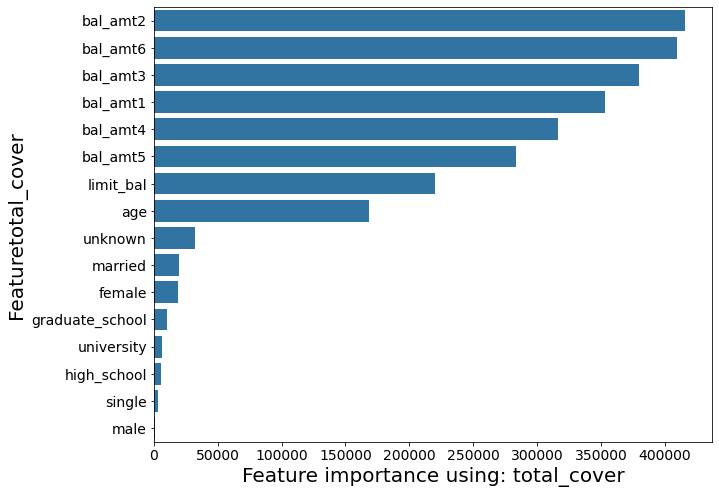

In [33]:
#Available importance_types = [‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]

pal = sns.color_palette('tab10')

feature_names = X_train_upsampled.columns

for importance in ['weight', 'gain', 'cover', 'total_gain', 'total_cover']:
    dict_imp = trained_xgb_tuned.get_booster().get_score(importance_type= importance)
    
    imp_df = pd.DataFrame.from_dict(dict_imp, orient='index', columns = ['values'])
    imp_df = imp_df.reset_index().sort_values(by='values', ascending = False)
    
    plt.figure(figsize = (10,8))
    ax = sns.barplot(x="values", y="index", data=imp_df, color = pal.as_hex()[0])
    plt.xticks(fontsize=14, rotation=0)
    
    y_ticks = []
    for item in ax.get_yticklabels():
        index_feature = int(item.get_text().replace('f', ''))
        y_ticks.append(feature_names[index_feature])
       
    ax.set_yticklabels(y_ticks)
    plt.yticks(fontsize=14, rotation=0)
    ax.set_xlabel("Feature importance using: " + importance, fontsize =20)
    ax.set_ylabel("Feature" + importance, fontsize =20);

## 3.1 Shap values on the train dataset

In [34]:
explainer = shap.Explainer(trained_xgb_tuned)

In [35]:
shap_values = explainer(X_train_upsampled)
#shap_values = explainer(X_train, X100)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [36]:
with open("model_artifacts/shap_values_train.pkl","wb") as f:
    pickle.dump(shap_values, f)

In [37]:
with open("model_artifacts/shap_values_train.pkl","rb") as f:
    shap_values = pickle.load(f)

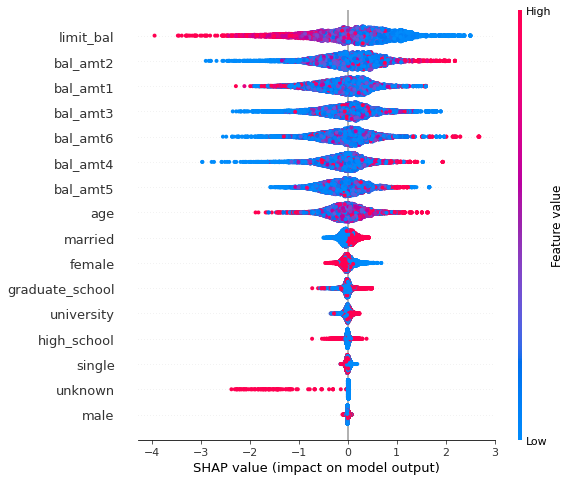

In [38]:
shap.initjs()
shap.summary_plot(shap_values, X_train_upsampled.values)

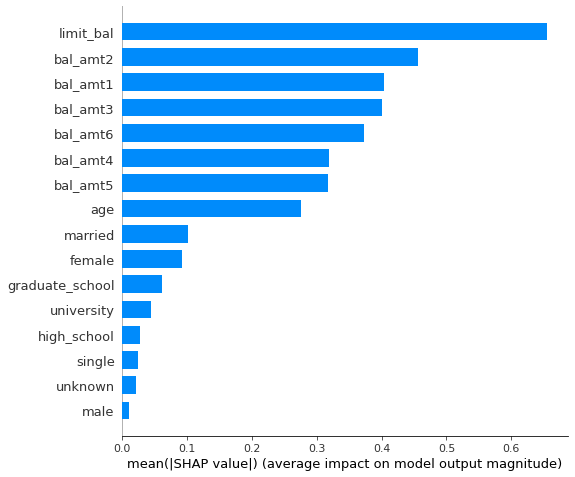

In [39]:
shap.summary_plot(shap_values, X_train_upsampled, plot_type="bar")

### The impact of each feature in a prediction

In [40]:
shap.initjs()
shap.plots.force(shap_values[0])

## 3.2 Shap values on the test dataset

In [41]:
explainer = shap.Explainer(trained_xgb_tuned)

In [42]:
shap_values = explainer(X_test)
#shap_values = explainer(X_train_upsampled, X100)

In [43]:
with open("model_artifacts/shap_values_test.pkl","wb") as f:
    pickle.dump(shap_values, f)

In [44]:
with open("model_artifacts/shap_values_test.pkl","rb") as f:
    shap_values = pickle.load(f)

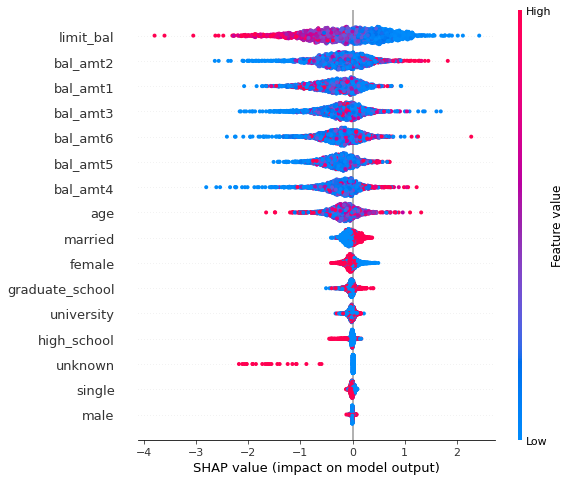

In [45]:
shap.initjs()
shap.summary_plot(shap_values, X_test.values)

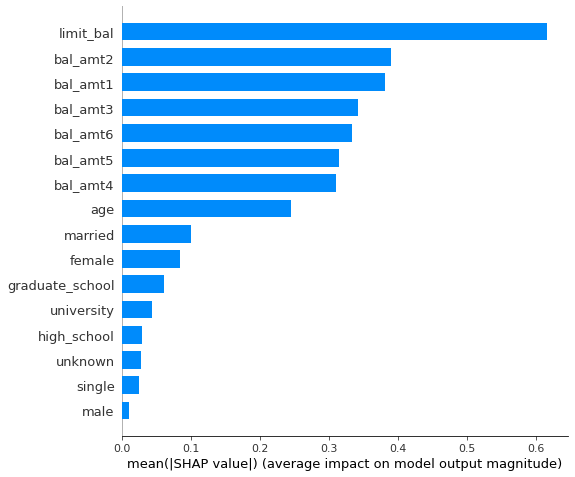

In [46]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

### The impact of each feature in a prediction

In [47]:
shap.initjs()
shap.plots.force(shap_values[0])

# 3.0 Avenues of improvement

Dataset and feature improvements:
- The categories with small number of records, could be merged into one, e.g. unknown and others

In terms of model training and evaluation:
- It seems that the dataset is overfitting the train dataset, thus having not so great result in the test, thefore this could be an area to improvement, perhaps creating including more features that allow the model to learn the dataset from another perspective (include the 